In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# test statistics
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# machine learning
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,FunctionTransformer,PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import (roc_auc_score,f1_score,
                             precision_recall_curve,
                             precision_score,
                             recall_score)

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
# As reported on Kaggle, a PCA has already been performed on features (V1,V2,V3...)
# The only features that are not passed through PCA (according to the documentation) are Time and Amount
# The class is the target variable
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Check for any null,nan or duplicates
def checking_func(df):
    if df.isnull().values.any():
        print('There are null values in the dataframe')
    else:
        print('No null values in the dataframe')
    if df.duplicated().values.any():
        print('There are duplicate values in the dataframe')
    else:
        print('No duplicate values in the dataframe')
    if df.isna().values.any():
        print('There are NaN values in the dataframe')
    else:
        print('No NaN values in the dataframe')

In [5]:
checking_func(df)

No null values in the dataframe
There are duplicate values in the dataframe
No NaN values in the dataframe


In [6]:
# There are some duplicates, keep it for now.
print(f"Total duplicated for positive class: {df[df['Class'] == 1].duplicated().sum()}")
print(f"Total duplicated for negative class: {df[df['Class'] == 0].duplicated().sum()}")

Total duplicated for positive class: 19
Total duplicated for negative class: 1062


# Exploratory Data Analysis

### Objectives:
1. **Attribute Study**
2. **Type Checking**
3. **Noisiness Assessment**
4. **Distribution Exploration**
5. **Transformation Potential**
6. **Data Visualization**

In [7]:
# Except for the target variable, every feature is of type 'float64'.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Class Imbalance

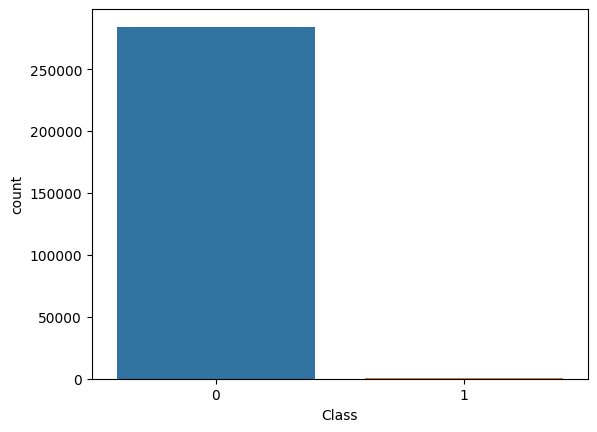

In [8]:
# As you may expected we got a strong imbalance in the target variable
sns.countplot(x='Class', data=df)
plt.show()

### Outliers

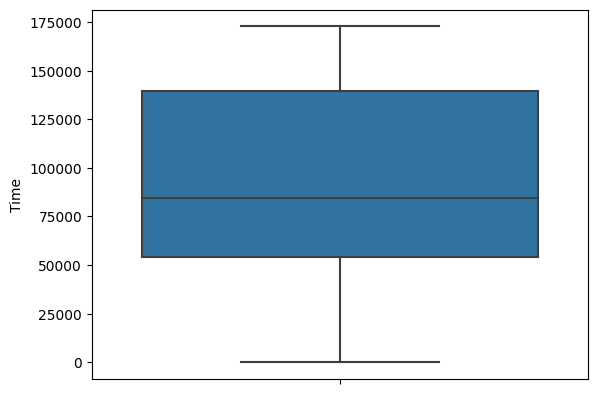

In [9]:
sns.boxplot(data=df,y=df['Time'])
plt.show()

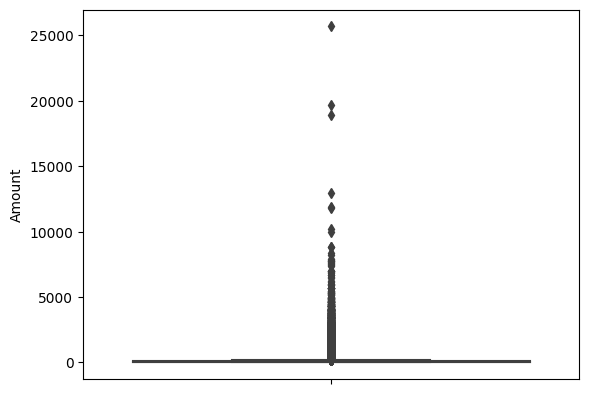

In [10]:
# Let's check for any outliers
sns.boxplot(data=df,y=df['Amount'])
plt.show()

In [11]:
features = df.iloc[:, 1:29].columns

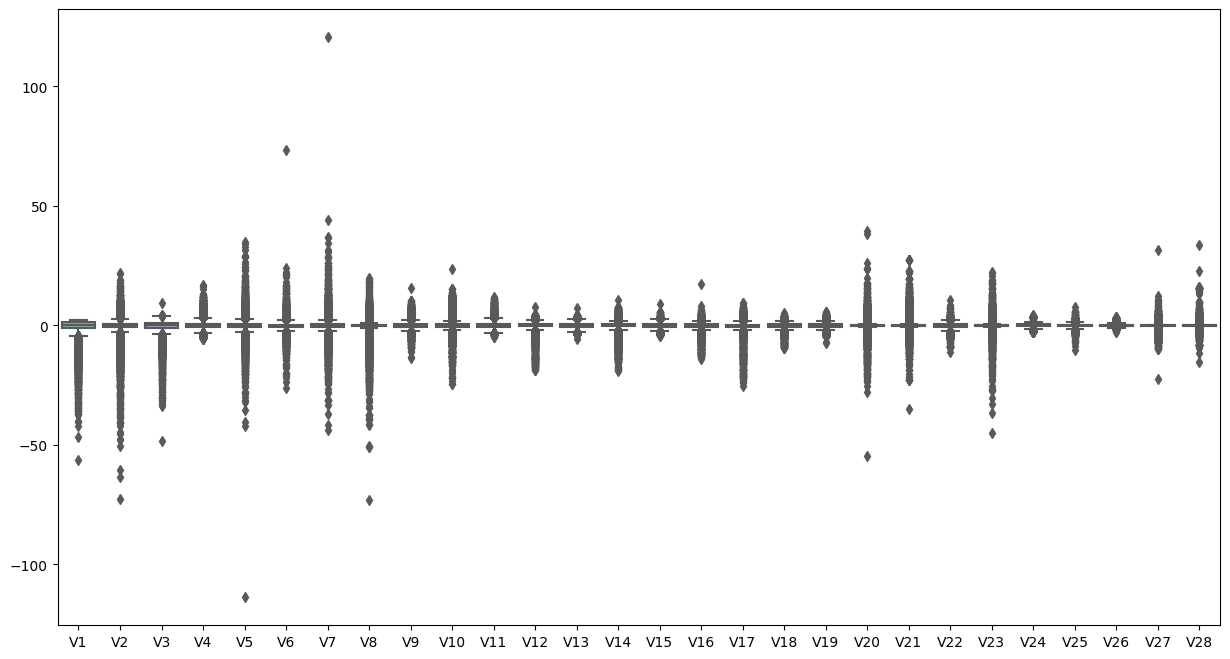

In [12]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df[features], orient="v", palette="Set2")
plt.show()

### Sample Selection

*Note*: Since the total of data are quite large, we will randomly sample the data to reduce the computation time.

In [13]:
N = 20000
sample = df.groupby('Class', group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)

# Since the Std and the mean of the population is known, lets compare it
print(f"Population mean: {df.mean().sum()},population Std: {df.std().sum()}")
print(f"Sample mean: {sample.mean().sum()},sample Std: {sample.std().sum()}")

Population mean: 94902.21092181724,population Std: 47765.64655087636
Sample mean: 94820.01072749992,sample Std: 47849.77543123892


In [14]:
# verify that the the difference between population and sample statistics are not significant
def t_test(df, sample):
    t_test = stats.ttest_ind(df, sample)
    p_value = t_test[1]
    if p_value < 0.05:
        print("We reject the null hypothesis")
    else:
        print("We fail to reject the null hypothesis")

In [15]:
# test on mean
t_test(df.mean(), sample.mean())

# test on Std
t_test(df.std(), sample.std())

# Compare the proportions of classes
print(f"Proportion of pos class in df: {df['Class'].sum()/len(df)}, in sample: {sample['Class'].sum()/len(sample)}")

We fail to reject the null hypothesis
We fail to reject the null hypothesis
Proportion of pos class in df: 0.001727485630620034, in sample: 0.00175


### Visualizations

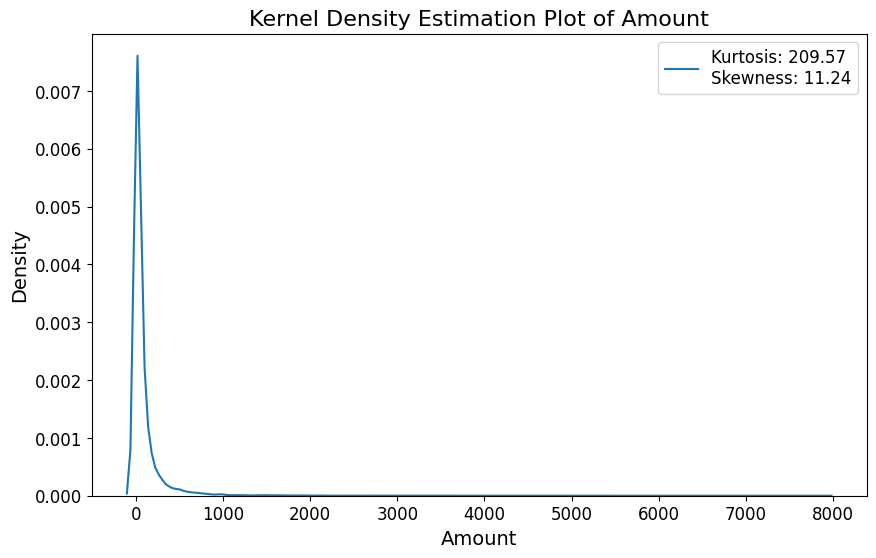

In [16]:
# The variable 'Amount' show a strong kurtosis and skewness.
plt.figure(figsize=(10, 6))
sns.kdeplot(data=sample, x="Amount", label=f"Kurtosis: {sample['Amount'].kurt():.2f}\nSkewness: {sample['Amount'].skew():.2f}")
plt.legend(loc='upper right', fontsize='large')
plt.title('Kernel Density Estimation Plot of Amount', fontsize=16)
plt.xlabel('Amount', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

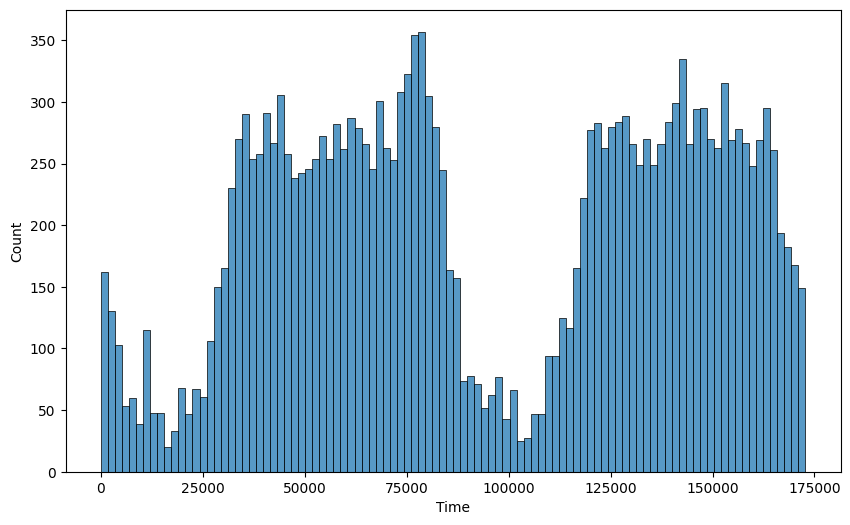

In [17]:
# Let's visualize the Time
plt.figure(figsize=(10, 6))
sns.histplot(data=sample,x='Time',bins=100,label='Time')
plt.show()

In [18]:
sample.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,129063.0,2.289514,-1.574852,-1.128711,-1.791780,-1.068691,-0.055914,-1.342566,0.025943,-1.110746,...,-0.182156,-0.106641,0.109873,-1.147944,-0.181996,-0.128155,0.006098,-0.067516,29.40,0
1,63555.0,1.196917,0.499183,0.090995,1.178233,0.002551,-1.018031,0.514884,-0.275699,-0.384463,...,0.070449,0.314455,-0.055089,0.639272,0.723545,-0.301145,0.012101,0.013849,1.48,0
2,75973.0,-0.519288,0.857109,1.613393,-0.135878,-0.045373,-0.242546,0.459128,0.273931,-0.490375,...,-0.147251,-0.429885,0.042834,0.171252,-0.363922,0.074784,0.269128,0.107098,6.28,0
3,140196.0,-0.194446,0.419320,-1.104514,-1.347811,1.932688,-0.680065,1.671171,-0.368725,-0.307214,...,0.232585,0.754281,-0.164874,-0.039251,-0.244139,0.056537,0.185576,0.042214,58.00,0
4,78686.0,1.231586,-0.413043,1.098834,-0.843303,-1.407439,-0.837886,-0.786304,0.001675,1.810669,...,0.267405,0.923146,-0.115746,0.404664,0.482778,-0.550712,0.102953,0.041372,8.00,0


In [19]:
columns_to_exclude = ['Time', 'Class', 'Amount']
# calculate skewness and kurtosis for each feature
skewness = sample.drop(columns=columns_to_exclude, axis=1).skew()
kurtosis = sample.drop(columns=columns_to_exclude, axis=1).kurtosis()
# create a DataFrame with the results
results = pd.concat([skewness, kurtosis], axis=1)
results.columns = ['skewness', 'kurtosis']
results.T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
skewness,-2.486493,-3.489573,-1.947626,0.580774,-1.543259,1.654018,0.082403,-9.066811,0.556849,1.126999,...,0.063189,2.225508,4.506575,-0.316712,-0.787062,-0.525703,-0.390670,0.532872,-2.328934,0.014033
kurtosis,18.068264,75.192829,20.992298,1.882708,37.228423,7.934499,74.098902,234.489700,3.749150,29.240808,...,1.578117,132.133434,195.751780,3.279575,245.333717,0.607485,2.400496,0.815912,83.441594,89.588513


In [20]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Calculate VIF for all features in 'sample'
vif_result = calculate_vif(sample.drop(['Time', 'Class', 'Amount'], axis=1))  # Exclude non-numeric columns if necessary

In [21]:
vif_result.T

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
Feature,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
VIF,1.030643,1.036126,1.008197,1.008141,1.005932,1.004764,1.007327,1.006365,1.00207,1.002659,...,1.003472,1.069,1.020835,1.003096,1.016591,1.001203,1.009323,1.002414,1.027202,1.043585


## Conclusion

### Sample Selection:
To facilitate computationally demanding analyses, I opted to use a sampled subset of the dataset to reduce execution time. Given the highly imbalanced nature of the dataset, I conducted a stratified sampling to maintain class proportions. Further statistical tests confirmed the sample's representativeness.

### Class Imbalance:
The dataset exhibits significant class imbalance, which is expected in fraud detection where anomalies are rare compared to normal transactions. Various techniques such as oversampling, undersampling, adjusting class weights, or using models robust to class imbalance are being considered.

### Outliers:
Despite the presence of numerous outliers, they hold valuable information in fraud detection. Instead of removing them outright, robust models like XGBoost or ensemble methods such as Random Forests are preferred, as they can effectively handle outliers.

### Visualizations:
Exploring the distributions of model features revealed interesting insights. The 'Amount' variable exhibits pronounced kurtosis and skewness, while 'Time' shows a unique tri-modal distribution. Individual features (V1, V2, ...) also display varying levels of kurtosis and skewness, highlighting areas for further investigation.

### VIF
Having already applied PCA to the data initially, VIF levels are well within acceptable ranges. This ensures no issues related to multicollinearity, affirming the robustness of the data preprocessing steps.

### Prepare the data:

- Data cleaning
- Feature engineering
- Feature Scaling

In [22]:
# make a copy of the dataset
sample_cp = sample.copy()

In [23]:
def log_trans(feature):
    return np.log1p(feature)

In [24]:
trans_features = [col for col in sample_cp.columns if col not in ['Time', 'Class', 'Amount']]

V_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('yeojohnson', PowerTransformer(method='yeo-johnson'))
])
amount_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('log_trans',FunctionTransformer(log_trans, validate=False))
])

time_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])
# Create a ColumnTransformer to apply log_trans to specific features
preprocessor = ColumnTransformer(transformers=[
    ('Vfeatures_preprocessor', V_pipeline, trans_features),
    ('Amount_preprocessor', amount_pipeline,['Amount']),
    ('Time_preprocessor', time_pipeline,['Time'])
], remainder='passthrough')

In [25]:
def final_pipeline(preprocessor,model):

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    return pipeline

### Test some models

#### We test some models that have proven to be good choices when it comes to unbalanced datasets

- Logistic Regression
- Random Forest
- XGBoost
- CatBoost
- Gradient Boosting

NOTE: *Logistic regression is used as naive model*

In [26]:
features = sample_cp.iloc[:, 0:30]
target = sample_cp['Class']

def stratified_kfold_metrics(model, X, y, n_splits=5, random_state=None):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    metrics_results = {
        'roc_auc_scores': [],
        'f1_scores': [],
        'precision_scores': [],
        'recall_scores': []
    }

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        metrics_results['roc_auc_scores'].append(roc_auc_score(y_test, y_pred))
        metrics_results['f1_scores'].append(f1_score(y_test, y_pred))
        metrics_results['precision_scores'].append(precision_score(y_test, y_pred))
        metrics_results['recall_scores'].append(recall_score(y_test, y_pred))

    # Calculate mean of scores across all folds
    mean_metrics = {
        'mean_roc_auc_score': np.mean(metrics_results['roc_auc_scores']),
        'mean_f1_score': np.mean(metrics_results['f1_scores']),
        'mean_precision_score': np.mean(metrics_results['precision_scores']),
        'mean_recall_score': np.mean(metrics_results['recall_scores'])
    }

    return mean_metrics, metrics_results


In [27]:
logreg = final_pipeline(preprocessor,LogisticRegression(random_state=42))
logreg_mean,_ = stratified_kfold_metrics(logreg, features,target, n_splits=5, random_state=42)

In [28]:
gbc = final_pipeline(preprocessor,GradientBoostingClassifier(random_state=42))
gbc_mean,_ = stratified_kfold_metrics(gbc, features,target, n_splits=5, random_state=42)

In [29]:
catboost = final_pipeline(preprocessor,CatBoostClassifier(random_state=42))
catboost_mean,_ = stratified_kfold_metrics(catboost, features,target, n_splits=5, random_state=42)

Learning rate set to 0.033658
0:	learn: 0.5856632	total: 426ms	remaining: 7m 5s
1:	learn: 0.4984911	total: 465ms	remaining: 3m 52s
2:	learn: 0.4147335	total: 522ms	remaining: 2m 53s
3:	learn: 0.3424543	total: 587ms	remaining: 2m 26s
4:	learn: 0.2888635	total: 606ms	remaining: 2m
5:	learn: 0.2379467	total: 620ms	remaining: 1m 42s
6:	learn: 0.2001593	total: 819ms	remaining: 1m 56s
7:	learn: 0.1695812	total: 869ms	remaining: 1m 47s
8:	learn: 0.1422368	total: 891ms	remaining: 1m 38s
9:	learn: 0.1191235	total: 937ms	remaining: 1m 32s
10:	learn: 0.1001862	total: 972ms	remaining: 1m 27s
11:	learn: 0.0860088	total: 1.24s	remaining: 1m 42s
12:	learn: 0.0726719	total: 1.26s	remaining: 1m 35s
13:	learn: 0.0616436	total: 1.28s	remaining: 1m 29s
14:	learn: 0.0520927	total: 1.29s	remaining: 1m 24s
15:	learn: 0.0446116	total: 1.31s	remaining: 1m 20s
16:	learn: 0.0379266	total: 1.33s	remaining: 1m 16s
17:	learn: 0.0320974	total: 1.34s	remaining: 1m 13s
18:	learn: 0.0271557	total: 1.36s	remaining: 1m 1

In [30]:
rfc = final_pipeline(preprocessor,RandomForestClassifier(random_state=42))
rfc_mean,_ = stratified_kfold_metrics(rfc, features,target, n_splits=5, random_state=42)

In [31]:
xgb = final_pipeline(preprocessor,XGBClassifier(random_state=42))
xgb_mean,_ = stratified_kfold_metrics(xgb,features,target, n_splits=5, random_state=42)

In [32]:
metrics = pd.DataFrame([logreg_mean,gbc_mean,catboost_mean,rfc_mean,xgb_mean],
                       index=['Logistic Regression',
                              'Gradient Boosting Classifier',
                              'CatBoost Classifier','Random Forest Classifier',
                              'XGBoost Classifier'])

In [33]:
metrics

,mean_roc_auc_score,mean_f1_score,mean_precision_score,mean_recall_score
Logistic Regression,0.885689,0.856410,0.966667,0.771429
Gradient Boosting Classifier,0.899800,0.790330,0.785714,0.800000
CatBoost Classifier,0.899950,0.860806,0.942857,0.800000
Random Forest Classifier,0.885689,0.850583,0.966667,0.771429
XGBoost Classifier,0.942832,0.922711,0.971429,0.885714


### Conclusion:

#### On unbalanced data XGBoost seems to be the better choice.

# Test the model on the entire dataset

In [34]:
X,y = df.drop('Class',axis=1),df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,
                                                    stratify=y) # stratify for imbalanced data

In [35]:
model = final_pipeline(preprocessor,XGBClassifier(random_state=42)).fit(X_train,y_train)

In [36]:
cross_validate = cross_val_score(model, X_test, y_test, cv=5, scoring='roc_auc')
print(f'Cross validation score: {cross_validate.mean()}')

Cross validation score: 0.9664981507722017


# Final Considerations

The dataset exhibits a high level of imbalance, prompting the use of robust models capable of handling this issue internally. Moreover, despite the presence of outliers, which can often provide crucial insights into the nature of fraud, I opted to retain them. The selected models are robust against outliers, supporting this decision.

The visualisation and testing phase of the models was carried out on a stratified sample of the original dataset consisting of 20000 observations, i.e. approximately 10% of the original dataset.
This choice was due to the particularly large size of the dataset, which would have made the training phase excessively long.
Furthermore, in order to verify that the sample is sufficiently representative, I wanted to perform t-tests to check that the mean and standard deviation are not too statistically significantly different from those of the original dataset (population).
The proportion of the target variable is also almost identical.

All models were trained using stratified k-fold cross-validation due to the significant class imbalance, ensuring a balanced representation of classes in each fold.

The variables were preprocessed taking into account the high level of kurtosis and skewness.
For this purpose, I opted for ad hoc transformations such as the logarithmic transformation for the variable 'Amount'
and the Yeo-Johnson transformation for the other variables V1,V2...
the choice of the Yeo-Johnson is due to the fact that this transformation is also capable of handling negative values and 0 values, as opposed (obviously) to the logarithmic function which, on the other hand, is mathematically undefined for values equal to or less than 0.

Finally, for training on the original dataset, I choose the XGBoost model, as it showed the best results in testing.
As a further verification, I also performed a cross-validation.

### Potential Options to Explore:

- **Oversampling or Undersampling:** Techniques to address the imbalance by adjusting the class distribution.

    note: *Be aware for overfitting*.
- **Optimize Hyperparameters:** Once the final model has been selected, it may be interesting to search for the best hyperparameters via GridSearch, RandomizedSearch or Bayesian optimization.
